<a href="https://colab.research.google.com/github/silversword86/-Detection-of-ALL-Cancer-by-Classifying-it-from-Non-Cancerous-Cells-with-CNN/blob/main/ALLclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from skimage import morphology
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
#eğitim veriçerçevesi
test_dizin ='/content/drive/My Drive/test/'
egitim_dizin = '/content/drive/My Drive/train/'

# Sınıfların listesi
siniflar = ['Benign', 'Malignant_early_Pre-B', 'Malignant_Pre-B', 'Malignant_Pro-B']

# Test veri setini oluşturma
test_data = []
for sinif in siniflar:
    class_dir = os.path.join(test_dizin, sinif)
    image_files = os.listdir(class_dir)
    for image_file in image_files:
        file_path = os.path.join(class_dir, image_file)
        test_data.append({'File': file_path, 'Label': sinif})

test_df = pd.DataFrame(test_data)

print('-- Test VeriÇerçevesi --')
print(test_df.head())
print('Test Verileri Sınıf Dağılımı:')
print(test_df['Label'].value_counts())

# Eğitim veri setini oluşturma
train_data = []
for sinif in siniflar:
    class_dir = os.path.join(egitim_dizin, sinif)
    image_files = os.listdir(class_dir)
    for image_file in image_files:
        file_path = os.path.join(class_dir, image_file)
        train_data.append({'File': file_path, 'Label': sinif})

train_df = pd.DataFrame(train_data)

print('-- Eğitim VeriÇerçevesi --')
print(train_df.head())
print('Eğitim Verileri Sınıf Dağılımı:')
print(train_df['Label'].value_counts())



-- Test VeriÇerçevesi --
                                              File   Label
0   /content/drive/My Drive/test/Benign/test_7.jpg  Benign
1  /content/drive/My Drive/test/Benign/test_25.jpg  Benign
2   /content/drive/My Drive/test/Benign/test_8.jpg  Benign
3  /content/drive/My Drive/test/Benign/test_16.jpg  Benign
4  /content/drive/My Drive/test/Benign/test_29.jpg  Benign
Test Verileri Sınıf Dağılımı:
Malignant_early_Pre-B    88
Malignant_Pre-B          88
Benign                   79
Malignant_Pro-B          75
Name: Label, dtype: int64
-- Eğitim VeriÇerçevesi --
                                                File   Label
0  /content/drive/My Drive/train/Benign/egitim_31...  Benign
1  /content/drive/My Drive/train/Benign/egitim_53...  Benign
2  /content/drive/My Drive/train/Benign/egitim_50...  Benign
3  /content/drive/My Drive/train/Benign/egitim_77...  Benign
4  /content/drive/My Drive/train/Benign/egitim_61...  Benign
Eğitim Verileri Sınıf Dağılımı:
Malignant_early_Pre-B    178

In [ ]:
SPLIT = 0.90

# Train ve Validation veri bölümlendirmesi
train_data, valid_data = train_test_split(train_data, train_size=SPLIT, shuffle=True, random_state=88)

# Train DataFrame oluşturma
train_df = pd.DataFrame(train_data)

print('-- Train DataFrame --')
print(train_df.head())
print('Train Data Class Distribution:')
print(train_df['Label'].value_counts())

# Validation DataFrame oluşturma
valid_df = pd.DataFrame(valid_data)

print('-- Validation DataFrame --')
print(valid_df.head())
print('Validation Data Class Distribution:')
print(valid_df['Label'].value_counts())

# Test DataFrame yazma
print('-- Test DataFrame --')
print(test_df.head())
print('Test Data Class Distribution:')
print(test_df['Label'].value_counts())


-- Train DataFrame --
                                                File                  Label
0  /content/drive/My Drive/train/Benign/egitim_31...                 Benign
1  /content/drive/My Drive/train/Malignant_early_...  Malignant_early_Pre-B
2  /content/drive/My Drive/train/Malignant_early_...  Malignant_early_Pre-B
3  /content/drive/My Drive/train/Malignant_early_...  Malignant_early_Pre-B
4  /content/drive/My Drive/train/Malignant_Pre-B/...        Malignant_Pre-B
Train Data Class Distribution:
Malignant_early_Pre-B    1624
Malignant_Pre-B          1539
Malignant_Pro-B          1276
Benign                    892
Name: Label, dtype: int64
-- Validation DataFrame --
                                                File            Label
0  /content/drive/My Drive/train/Malignant_Pro-B/...  Malignant_Pro-B
1  /content/drive/My Drive/train/Malignant_Pro-B/...  Malignant_Pro-B
2  /content/drive/My Drive/train/Malignant_Pre-B/...  Malignant_Pre-B
3  /content/drive/My Drive/train/Malig

In [ ]:
#Augmentation (artırma), normalize etme ve veri üreteci (data generator) oluşturma
# Veri artırma ve normalizasyon parametreleri
batch_size = 32
image_size = (224, 224)

# Veri artırma işlemleri
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale piksel değerlerini [0, 255] aralığından [0, 1] aralığına normalize eder
    rotation_range=20,  # Rastgele döndürme işlemi uygular
    width_shift_range=0.2,  # Genişlik yönünde kayma uygular
    height_shift_range=0.2,  # Yükseklik yönünde kayma uygular
    shear_range=0.2,  # Kesme dönüşümü uygular
    zoom_range=0.2,  # Yakınlaştırma dönüşümü uygular
    horizontal_flip=True,  # Yatay simetri dönüşümü uygular
    fill_mode='nearest'  # Dolgu modunu belirler
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Sadece rescale işlemi yapılır

# Veri üreteci oluşturma
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=egitim_dizin,
    x_col='File',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle=True,
    seed=88
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=egitim_dizin,
    x_col='File',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Sadece rescale işlemi yapılır

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dizin,
    x_col='File',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle=False
)


Found 5331 validated image filenames belonging to 4 classes.
Found 593 validated image filenames belonging to 4 classes.
Found 330 validated image filenames belonging to 4 classes.


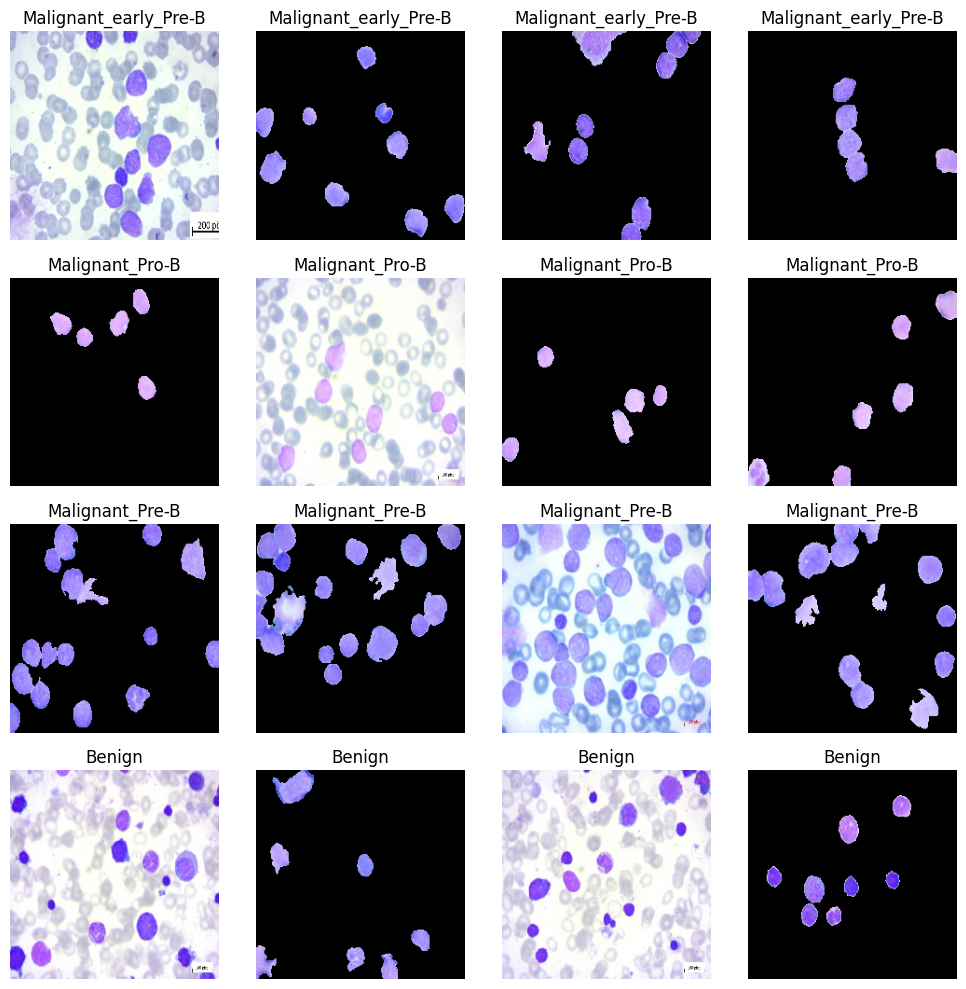

In [ ]:
siniflar = os.listdir(egitim_dizin)

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 4

for i, sinif in enumerate(siniflar):
    sinif_dizini = os.path.join(egitim_dizin, sinif)
    goruntuler = os.listdir(sinif_dizini)
    secilen_goruntuler = random.sample(goruntuler, 4)

    for j, goruntu in enumerate(secilen_goruntuler):
        goruntu_yolu = os.path.join(sinif_dizini, goruntu)
        img = Image.open(goruntu_yolu)
        fig.add_subplot(rows, columns, i*4+j+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(sinif)

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Model oluşturma
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False
)

# Adam optimizer kullanımı
optimizer = Adam(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Modeli eğitme
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    workers=2
)


Epoch 1/30
167/167 [==============================] - 789s 5s/step - loss: 0.4688 - accuracy: 0.8391 - val_loss: 0.6132 - val_accuracy: 0.8061
Epoch 2/30
167/167 [==============================] - 87s 517ms/step - loss: 0.1838 - accuracy: 0.9379 - val_loss: 0.0907 - val_accuracy: 0.9612
Epoch 3/30
167/167 [==============================] - 83s 494ms/step - loss: 0.1424 - accuracy: 0.9525 - val_loss: 0.0578 - val_accuracy: 0.9730
Epoch 4/30
167/167 [==============================] - 88s 523ms/step - loss: 0.1111 - accuracy: 0.9608 - val_loss: 0.0940 - val_accuracy: 0.9713
Epoch 5/30
167/167 [==============================] - 88s 523ms/step - loss: 0.0935 - accuracy: 0.9694 - val_loss: 0.0532 - val_accuracy: 0.9781
Epoch 6/30
167/167 [==============================] - 88s 524ms/step - loss: 0.0761 - accuracy: 0.9730 - val_loss: 0.0434 - val_accuracy: 0.9848
Epoch 7/30
167/167 [==============================] - 87s 516ms/step - loss: 0.0792 - accuracy: 0.9730 - val_loss: 0.0399 - val_accu

In [ ]:
model_path = '/content/drive/My Drive/MobilNet_Adam_ALL'  # Kaydetmek istediğiniz dosya yolu

tf.saved_model.save(model, model_path)

11/11 [==============================] - 74s 7s/step


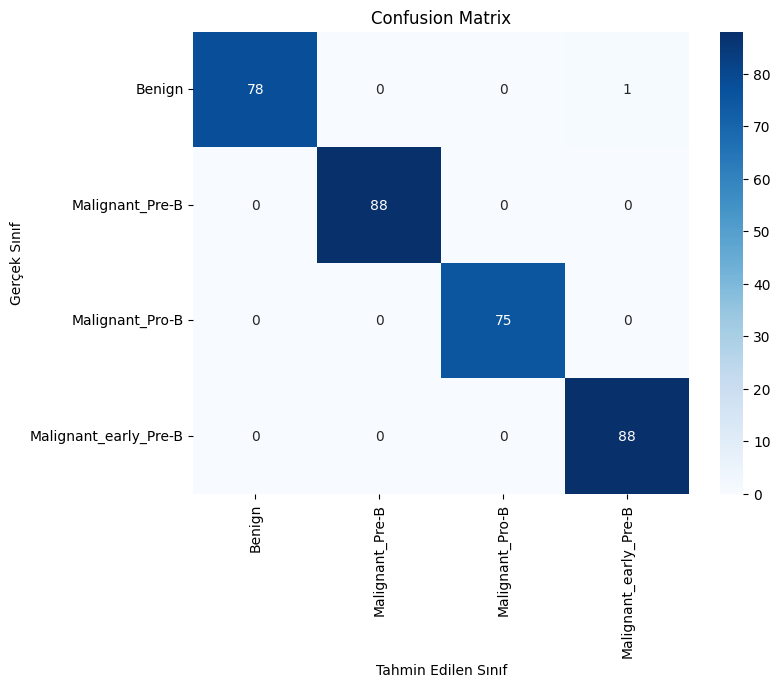

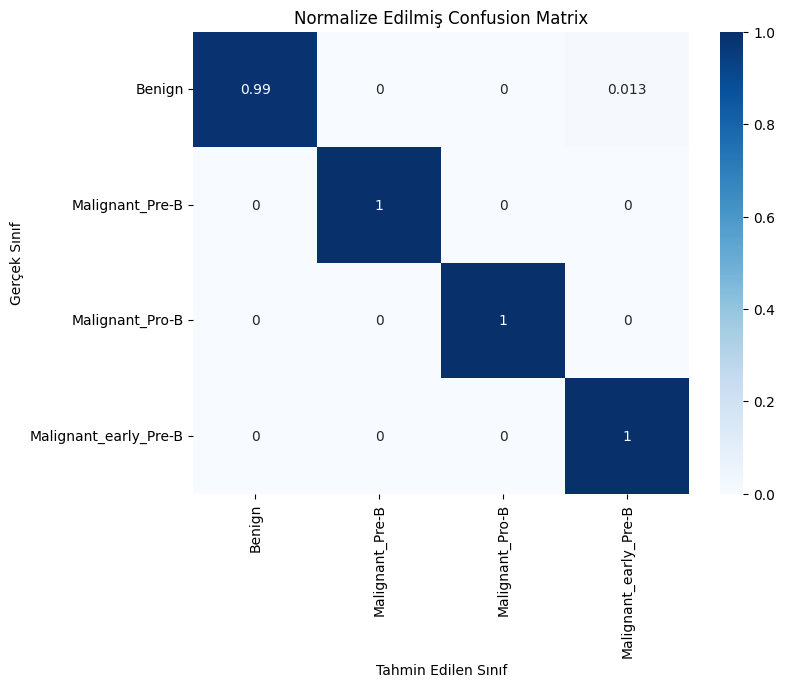

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test verileri ve tahminlerini alın
test_data = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion matrix'i hesaplayın
cm = confusion_matrix(test_data, predicted_labels)

# Sınıf etiketlerini alın
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix'i görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()

# Confusion matrix'i normalize edin
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Normalize edilmiş confusion matrix'i görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Normalize Edilmiş Confusion Matrix')
plt.show()


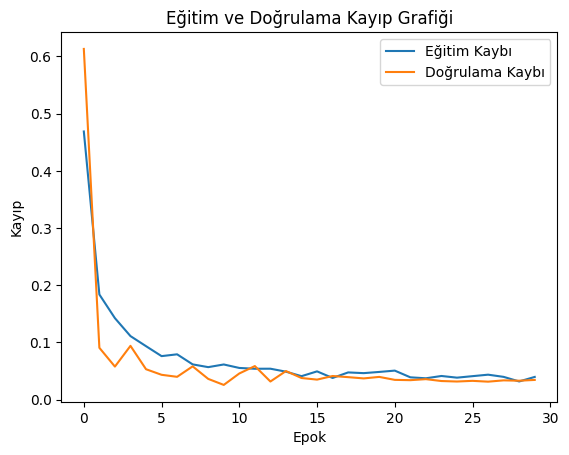

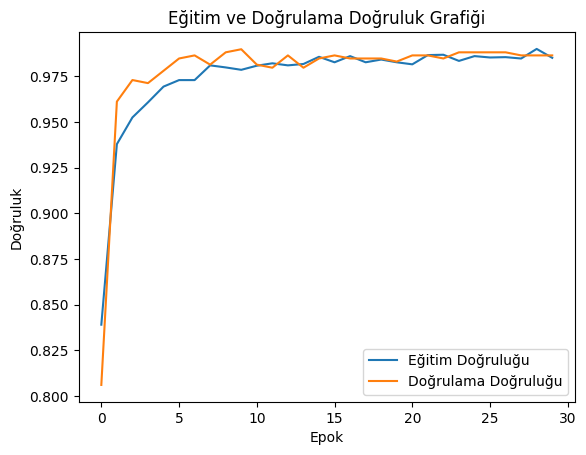

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıpları
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim ve doğrulama doğrulukları
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Eğitim ve doğrulama kayıp grafiği
plt.plot(train_loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Doğrulama Kaybı')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kayıp Grafiği')
plt.legend()
plt.show()

# Eğitim ve doğrulama doğruluk grafiği
plt.plot(train_accuracy, label='Eğitim Doğruluğu')
plt.plot(val_accuracy, label='Doğrulama Doğruluğu')
plt.xlabel('Epok')
plt.ylabel('Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluk Grafiği')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator

# Test verilerinin gerçek etiketlerini al
y_true = test_generator.classes

# Modelin tahminlerini al
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Kesinlik (Precision), Duyarlılık (Recall), F1 Skoru ve Doğruluk (Accuracy) hesaplamaları
class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
y_true_labels = [class_labels[label] for label in y_true]
y_pred_labels = [class_labels[label] for label in y_pred]

# One-hot encoding'i tersine çevir
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true_labels)
y_pred_bin = lb.transform(y_pred_labels)

# Metrikleri hesapla
precision = precision_score(y_true_bin, y_pred_bin, average='weighted')
recall = recall_score(y_true_bin, y_pred_bin, average='weighted')
f1 = f1_score(y_true_bin, y_pred_bin, average='weighted')
accuracy = accuracy_score(y_true_bin, y_pred_bin)

# Sınıf bazlı rapor
class_report = classification_report(y_true_bin, y_pred_bin, target_names=siniflar)

# Sonuçları ekrana yazdırma
print(f'Kesinlik (Precision): {precision}')
print(f'Duyarlılık (Recall): {recall}')
print(f'F1 Skoru: {f1}')
print(f'Doğruluk (Accuracy): {accuracy}')
print('\nSınıf Bazlı Rapor:\n', class_report)


11/11 [==============================] - 2s 161ms/step
Kesinlik (Precision): 0.997003745318352
Duyarlılık (Recall): 0.996969696969697
F1 Skoru: 0.9969686065011553
Doğruluk (Accuracy): 0.996969696969697

Sınıf Bazlı Rapor:
                        precision    recall  f1-score   support

Malignant_early_Pre-B       1.00      0.99      0.99        79
      Malignant_Pro-B       1.00      1.00      1.00        88
      Malignant_Pre-B       1.00      1.00      1.00        75
               Benign       0.99      1.00      0.99        88

            micro avg       1.00      1.00      1.00       330
            macro avg       1.00      1.00      1.00       330
         weighted avg       1.00      1.00      1.00       330
          samples avg       1.00      1.00      1.00       330



In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Model oluşturma
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False
)

# RMSprop optimizer kullanımı
optimizer = RMSprop(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Modeli eğitme
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    workers=2
)


17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/30
167/167 [==============================] - 2105s 12s/step - loss: 0.4135 - accuracy: 0.8554 - val_loss: 0.2929 - val_accuracy: 0.8836
Epoch 2/30
167/167 [==============================] - 83s 490ms/step - loss: 0.1641 - accuracy: 0.9415 - val_loss: 0.2609 - val_accuracy: 0.9275
Epoch 3/30
167/167 [==============================] - 86s 512ms/step - loss: 0.1248 - accuracy: 0.9580 - val_loss: 0.0475 - val_accuracy: 0.9781
Epoch 4/30
167/167 [==============================] - 89s 528ms/step - loss: 0.0977 - accuracy: 0.9664 - val_loss: 0.0372 - val_accuracy: 0.9899
Epoch 5/30
167/167 [==============================] - 89s 525ms/step - loss: 0.0924 - accuracy: 0.9672 - val_loss: 0.0723 - val_accuracy: 0.9713
Epoch 6/30
167/167 [==============================] - 82s 485ms/step - loss: 0.0712 - accuracy: 0.9739 - val_loss: 0.0532 - val_accuracy: 0.9798
Epoch 7/30
167/167 [==============================] - 89s 520ms/s

In [ ]:
# Eğitilmiş modeli kaydetme
saved_model_path = '/content/drive/My Drive/MobileNet_RMSProp'
tf.saved_model.save(model, saved_model_path)


ValueError: Expected an object of type `Trackable`, such as `tf.Module` or a subclass of the `Trackable` class, for export. Got /content/drive/My Drive/MobilNet_RmsProp with type <class 'str'>.

In [ ]:
model_path = '/content/drive/My Drive/MobilNet_Adam_RMSrop'  # Kaydetmek istediğiniz dosya yolu

tf.saved_model.save(model, model_path)

ValueError: Expected an object of type `Trackable`, such as `tf.Module` or a subclass of the `Trackable` class, for export. Got /content/drive/My Drive/MobilNet_RmsProp with type <class 'str'>.

11/11 [==============================] - 82s 8s/step


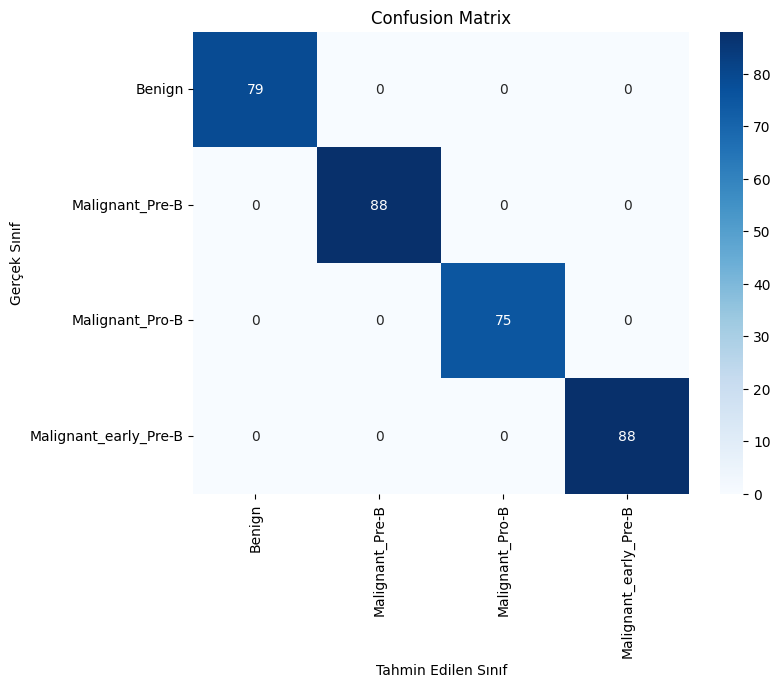

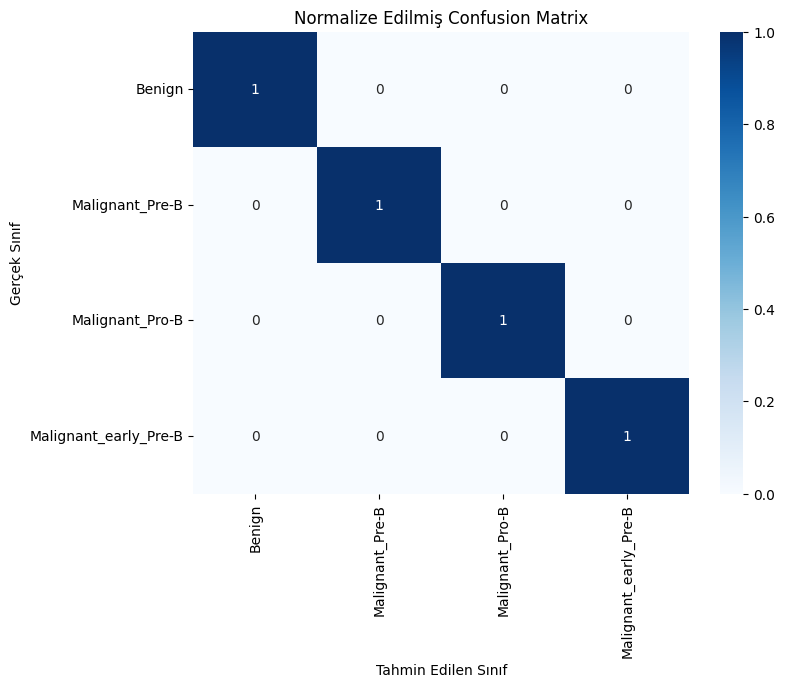

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test verileri ve tahminlerini alın
test_data = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion matrix'i hesaplayın
cm = confusion_matrix(test_data, predicted_labels)

# Sınıf etiketlerini alın
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix'i görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()

# Confusion matrix'i normalize edin
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Normalize edilmiş confusion matrix'i görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Normalize Edilmiş Confusion Matrix')
plt.show()


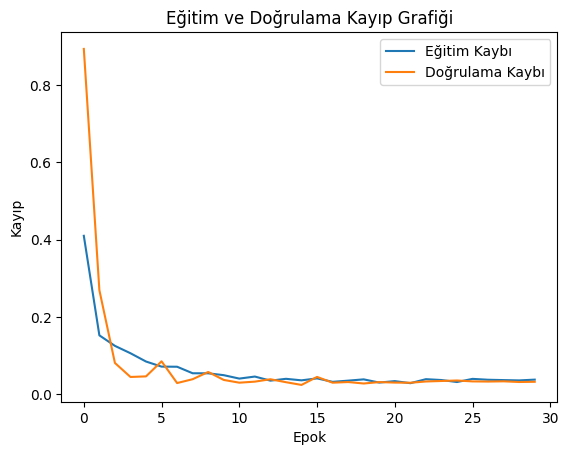

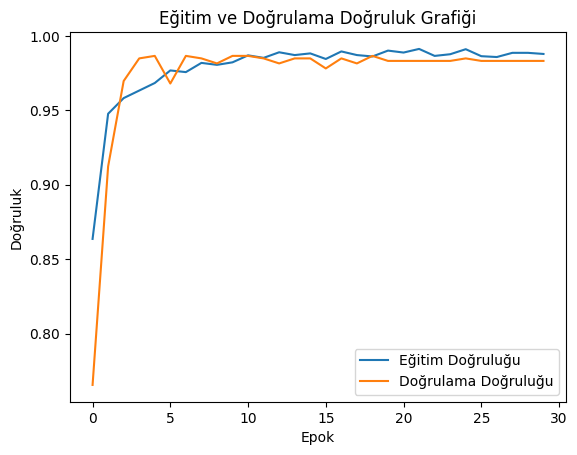

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıpları
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim ve doğrulama doğrulukları
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Eğitim ve doğrulama kayıp grafiği
plt.plot(train_loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Doğrulama Kaybı')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kayıp Grafiği')
plt.legend()
plt.show()

# Eğitim ve doğrulama doğruluk grafiği
plt.plot(train_accuracy, label='Eğitim Doğruluğu')
plt.plot(val_accuracy, label='Doğrulama Doğruluğu')
plt.xlabel('Epok')
plt.ylabel('Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluk Grafiği')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator

# Test verilerinin gerçek etiketlerini al
y_true = test_generator.classes

# Modelin tahminlerini al
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Kesinlik (Precision), Duyarlılık (Recall), F1 Skoru ve Doğruluk (Accuracy) hesaplamaları
class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
y_true_labels = [class_labels[label] for label in y_true]
y_pred_labels = [class_labels[label] for label in y_pred]

# One-hot encoding'i tersine çevir
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true_labels)
y_pred_bin = lb.transform(y_pred_labels)

# Metrikleri hesapla
precision = precision_score(y_true_bin, y_pred_bin, average='weighted')
recall = recall_score(y_true_bin, y_pred_bin, average='weighted')
f1 = f1_score(y_true_bin, y_pred_bin, average='weighted')
accuracy = accuracy_score(y_true_bin, y_pred_bin)

# Sınıf bazlı rapor
class_report = classification_report(y_true_bin, y_pred_bin, target_names=siniflar)

# Sonuçları ekrana yazdırma
print(f'Kesinlik (Precision): {precision}')
print(f'Duyarlılık (Recall): {recall}')
print(f'F1 Skoru: {f1}')
print(f'Doğruluk (Accuracy): {accuracy}')
print('\nSınıf Bazlı Rapor:\n', class_report)


11/11 [==============================] - 3s 202ms/step
Kesinlik (Precision): 1.0
Duyarlılık (Recall): 1.0
F1 Skoru: 1.0
Doğruluk (Accuracy): 1.0

Sınıf Bazlı Rapor:
                        precision    recall  f1-score   support

Malignant_early_Pre-B       1.00      1.00      1.00        79
      Malignant_Pro-B       1.00      1.00      1.00        88
      Malignant_Pre-B       1.00      1.00      1.00        75
               Benign       1.00      1.00      1.00        88

            micro avg       1.00      1.00      1.00       330
            macro avg       1.00      1.00      1.00       330
         weighted avg       1.00      1.00      1.00       330
          samples avg       1.00      1.00      1.00       330



In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Model oluşturma
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False
)

# SGD optimizer kullanımı
optimizer = SGD(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Modeli eğitme
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    workers=2
)


17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/30
167/167 [==============================] - 584s 3s/step - loss: 1.9632 - accuracy: 0.3138 - val_loss: 1.4615 - val_accuracy: 0.4536
Epoch 2/30
167/167 [==============================] - 76s 450ms/step - loss: 1.3358 - accuracy: 0.4909 - val_loss: 0.9191 - val_accuracy: 0.6459
Epoch 3/30
167/167 [==============================] - 81s 479ms/step - loss: 1.0754 - accuracy: 0.5860 - val_loss: 0.7038 - val_accuracy: 0.7369
Epoch 4/30
167/167 [==============================] - 80s 475ms/step - loss: 0.9931 - accuracy: 0.6258 - val_loss: 0.6053 - val_accuracy: 0.7943
Epoch 5/30
167/167 [==============================] - 77s 458ms/step - loss: 0.9009 - accuracy: 0.6637 - val_loss: 0.5424 - val_accuracy: 0.8078
Epoch 6/30
167/167 [==============================] - 76s 452ms/step - loss: 0.8845 - accuracy: 0.6691 - val_loss: 0.5129 - val_accuracy: 0.8128
Epoch 7/30
167/167 [==============================] - 80s 474ms/ste

In [ ]:
model_path = '/content/drive/My Drive/MobilNet_Adam_SGD'  # Kaydetmek istediğiniz dosya yolu

tf.saved_model.save(model, model_path)

11/11 [==============================] - 72s 7s/step


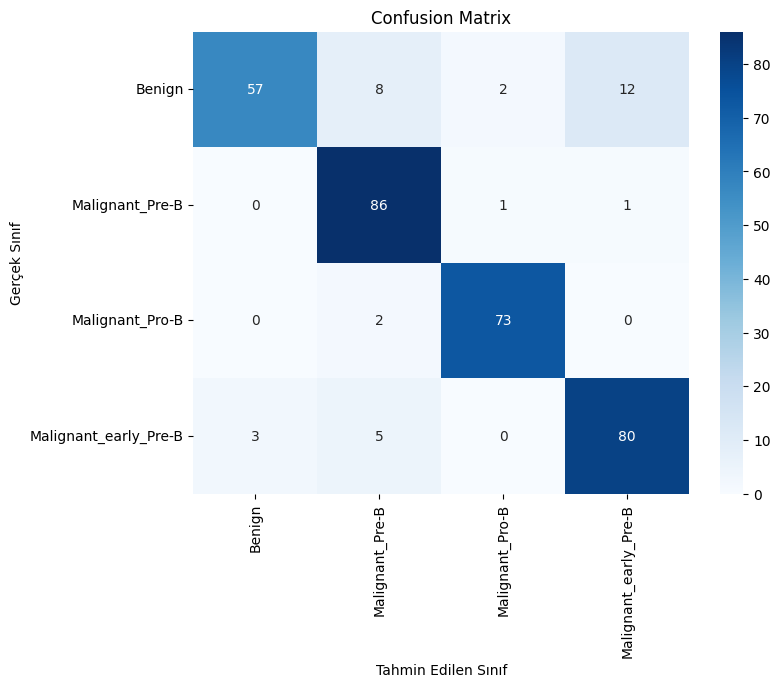

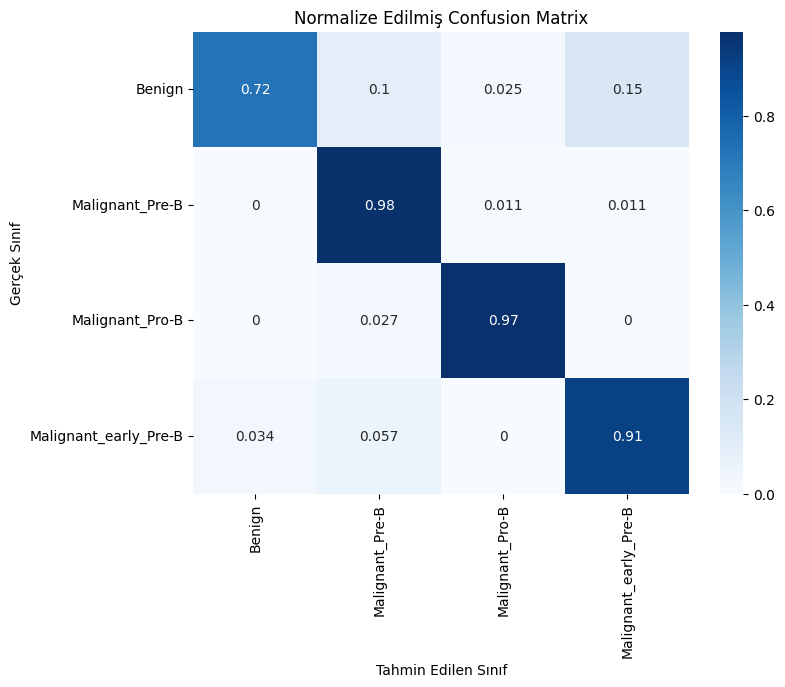

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test verileri ve tahminlerini alın
test_data = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion matrix'i hesaplayın
cm = confusion_matrix(test_data, predicted_labels)

# Sınıf etiketlerini alın
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix'i görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()

# Confusion matrix'i normalize edin
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Normalize edilmiş confusion matrix'i görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Normalize Edilmiş Confusion Matrix')
plt.show()


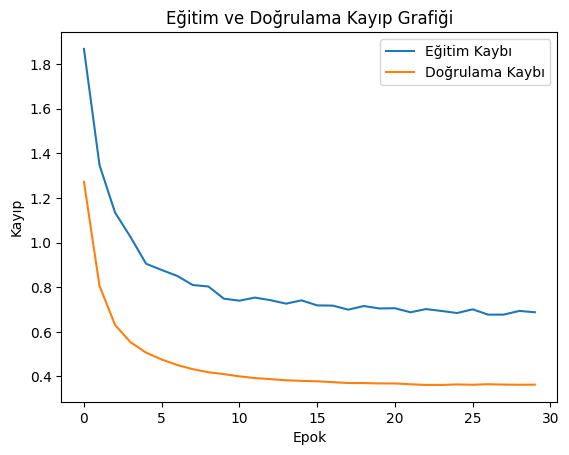

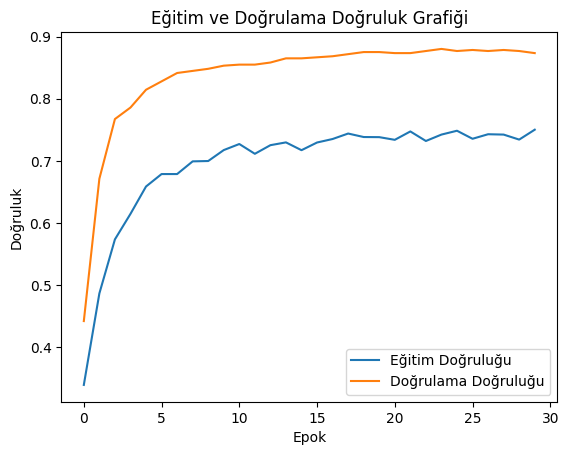

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıpları
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim ve doğrulama doğrulukları
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Eğitim ve doğrulama kayıp grafiği
plt.plot(train_loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Doğrulama Kaybı')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kayıp Grafiği')
plt.legend()
plt.show()

# Eğitim ve doğrulama doğruluk grafiği
plt.plot(train_accuracy, label='Eğitim Doğruluğu')
plt.plot(val_accuracy, label='Doğrulama Doğruluğu')
plt.xlabel('Epok')
plt.ylabel('Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluk Grafiği')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator

# Test verilerinin gerçek etiketlerini al
y_true = test_generator.classes

# Modelin tahminlerini al
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Kesinlik (Precision), Duyarlılık (Recall), F1 Skoru ve Doğruluk (Accuracy) hesaplamaları
class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
y_true_labels = [class_labels[label] for label in y_true]
y_pred_labels = [class_labels[label] for label in y_pred]

# One-hot encoding'i tersine çevir
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true_labels)
y_pred_bin = lb.transform(y_pred_labels)

# Metrikleri hesapla
precision = precision_score(y_true_bin, y_pred_bin, average='weighted')
recall = recall_score(y_true_bin, y_pred_bin, average='weighted')
f1 = f1_score(y_true_bin, y_pred_bin, average='weighted')
accuracy = accuracy_score(y_true_bin, y_pred_bin)

# Sınıf bazlı rapor
class_report = classification_report(y_true_bin, y_pred_bin, target_names=siniflar)

# Sonuçları ekrana yazdırma
print(f'Kesinlik (Precision): {precision}')
print(f'Duyarlılık (Recall): {recall}')
print(f'F1 Skoru: {f1}')
print(f'Doğruluk (Accuracy): {accuracy}')
print('\nSınıf Bazlı Rapor:\n', class_report)


11/11 [==============================] - 2s 191ms/step
Kesinlik (Precision): 0.8845225290938153
Duyarlılık (Recall): 0.8787878787878788
F1 Skoru: 0.8754264791200013
Doğruluk (Accuracy): 0.8787878787878788

Sınıf Bazlı Rapor:
                        precision    recall  f1-score   support

               Benign       0.95      0.71      0.81        79
Malignant_early_Pre-B       0.83      0.97      0.89        88
      Malignant_Pre-B       0.89      1.00      0.94        75
      Malignant_Pro-B       0.87      0.84      0.86        88

            micro avg       0.88      0.88      0.88       330
            macro avg       0.89      0.88      0.88       330
         weighted avg       0.88      0.88      0.88       330
          samples avg       0.88      0.88      0.88       330



In [ ]:
import tensorflow as tf

# Kaydedilmiş modelin dosya yolu
saved_model_path = '/content/drive/My Drive/MobilNet_RmsProp'

# Modeli yükleme
loaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
# TensorFlow Lite Converter'ı oluşturun ve modeli dönüştürün
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Dönüştürülmüş modeli dosyaya kaydedin
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)

from google.colab import files
files.download("converted_model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf

# Kaydedilmiş modelin dosya yolu
saved_model_path = '/content/drive/My Drive/MobilNet_RmsProp'

# Modeli yükleme
loaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
# TensorFlow Lite Converter'ı oluşturun ve modeli dönüştürün
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Dönüştürülmüş modeli dosyaya kaydedin
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)

from google.colab import files
files.download("converted_model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>